### Use Spark NLP for Text Classification

* Spark NLP is an open-source text processing library for advanced natural language processing for the Python, Java and Scala programming languages.

* The library is built on top of Apache Spark and its Spark ML library.

* It is currently the most widely used NLP library in the enterprise.

* In this tutorial, we will learn how to use Spark NLP for text preprocessing and build machine learning models to classify text into different categories.

In [ ]:
# Install pyspark
! pip install pyspark --quiet

# Install Spark NLP
! pip install spark-nlp --quiet

In [ ]:
# Import modules
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql.functions import expr
from pyspark.sql import functions as fun
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
import sparknlp
from sparknlp import DocumentAssembler, Finisher
from sparknlp.annotator import *
from pyspark.ml.classification import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *

In [ ]:
# Wrap strings when printing in Colab
from IPython.display import HTML, display
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
# Mount my google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## BBC News Summary Dataset

Sources: https://www.kaggle.com/datasets/pariza/bbc-news-summary; http://mlg.ucd.ie/datasets/bbc.html

\
The dataset consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005. There are five class Labels: business, entertainment, politics, sport, and tech.

\
Dataset structure:

\
* News Articles
  * business (txt files, e.g., 001.txt)
  * entertainment (txt files)
  * politics (txt files)
  * sport (txt files)
  * tech (txt files)

\
* Summaries
  * business (txt files, e.g., 001.txt)
  * entertainment (txt files)
  * politics (txt files)
  * sport (txt files)
  * tech (txt files)

In [ ]:
# Start the Spark NLP session
spark = sparknlp.start()

In [ ]:
# In Spark NLP, wholeTextFile() will return an error when it finds a nested folder. 
# Therefore, we need to create a file path list by traversing all nested folders 
# and pass all file names with comma separator in order to create a single RDD.
root = '/content/drive/My Drive/YouTube Channel/Datasets/BBC News Summary/Summaries'
lst_filenames = [os.path.join(path, name) for path, subdirs, files 
                 in os.walk(root) for name in files]
print(len(lst_filenames))
lst_filenames[:5]

2225


['/content/drive/My Drive/YouTube Channel/Datasets/BBC News Summary/Summaries/business/001.txt',
 '/content/drive/My Drive/YouTube Channel/Datasets/BBC News Summary/Summaries/business/003.txt',
 '/content/drive/My Drive/YouTube Channel/Datasets/BBC News Summary/Summaries/business/029.txt',
 '/content/drive/My Drive/YouTube Channel/Datasets/BBC News Summary/Summaries/business/021.txt',
 '/content/drive/My Drive/YouTube Channel/Datasets/BBC News Summary/Summaries/business/014.txt']

In [ ]:
# Use Spark NLP to import all txt files in the list (filenames seperated by comma)
texts = spark.sparkContext.wholeTextFiles(','.join(lst_filenames))

In [ ]:
# Create a schema for the imported files
schema = StructType([
  StructField('filename', StringType()),
  StructField('text', StringType())
])

In [ ]:
# Create a Spark NLP dataframe
texts = spark.createDataFrame(texts, schema = schema)
texts.show()

+--------------------+--------------------+
|            filename|                text|
+--------------------+--------------------+
|file:/content/dri...|TimeWarner said f...|
|file:/content/dri...|Yukos' owner Mena...|
|file:/content/dri...|The Vestey Group ...|
|file:/content/dri...|Leisure group Ran...|
|file:/content/dri...|"Journalists are ...|
|file:/content/dri...|The breakneck pac...|
|file:/content/dri...|India's rupee has...|
|file:/content/dri...|In 2003, crop pro...|
|file:/content/dri...|But officials sai...|
|file:/content/dri...|Crude oil prices ...|
|file:/content/dri...|On Tuesday, the c...|
|file:/content/dri...|The dollar has hi...|
|file:/content/dri...|The court ruling ...|
|file:/content/dri...|Rod Eddington, BA...|
|file:/content/dri...|A US government c...|
|file:/content/dri...|The Commerce Depa...|
|file:/content/dri...|The affected vehi...|
|file:/content/dri...|Ask Jeeves has be...|
|file:/content/dri...|Despite the appar...|
|file:/content/dri...|The job ga

In [ ]:
# We can convert the Spark NLP dataframe to Pandas dataframe
texts.limit(5).toPandas()

,filename,text
0,file:/content/drive/My Drive/YouTube Channel/D...,TimeWarner said fourth quarter sales rose 2% t...
1,file:/content/drive/My Drive/YouTube Channel/D...,Yukos' owner Menatep Group says it will ask Ro...
2,file:/content/drive/My Drive/YouTube Channel/D...,The Vestey Group said it had owned the land si...
3,file:/content/drive/My Drive/YouTube Channel/D...,Leisure group Rank could unveil plans to demer...
4,file:/content/drive/My Drive/YouTube Channel/D...,"""Journalists are the lifeblood of any newspape..."


In [ ]:
# Create a new column that stores the article topics for the text summarries
# Note: getItem will get the item by its index, which starts from 0
texts = texts.withColumn(
  'topic',
  fun.split('filename', '/').getItem(8)
  )

In [ ]:
 # Take a look at the newly created label column
texts.limit(5).toPandas()

,filename,text,topic
0,file:/content/drive/My Drive/YouTube Channel/D...,TimeWarner said fourth quarter sales rose 2% t...,business
1,file:/content/drive/My Drive/YouTube Channel/D...,Yukos' owner Menatep Group says it will ask Ro...,business
2,file:/content/drive/My Drive/YouTube Channel/D...,The Vestey Group said it had owned the land si...,business
3,file:/content/drive/My Drive/YouTube Channel/D...,Leisure group Rank could unveil plans to demer...,business
4,file:/content/drive/My Drive/YouTube Channel/D...,"""Journalists are the lifeblood of any newspape...",business


([<matplotlib.axis.XTick at 0x7f1967b9d690>,
 [Text(0, 0, 'politics'),
  Text(0, 0, 'entertainment'),
  Text(0, 0, 'business'),
  Text(0, 0, 'sport'),
  Text(0, 0, 'tech')])

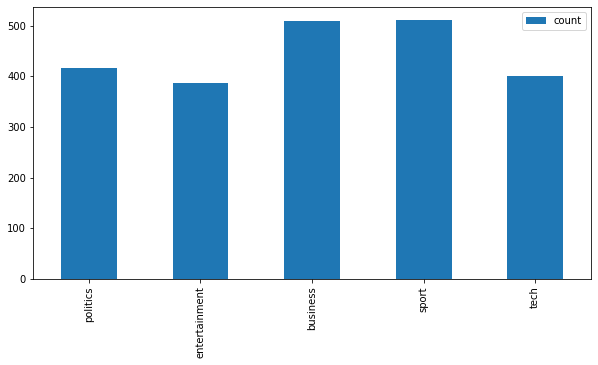

In [ ]:
# Take a look at the number of documents pertaining to each label
label_counts = texts.groupBy('topic').count().toPandas()
label_counts.plot(kind = 'bar', figsize = (10, 5))
plt.xticks(
  ticks = range(len(label_counts)),
  labels = label_counts['topic']
 )

In [ ]:
# Take a look at the schema of the Spark NLP dataframe
texts.printSchema()

root
 |-- filename: string (nullable = true)
 |-- text: string (nullable = true)
 |-- topic: string (nullable = true)



In [ ]:
# Randomly split the Spark NLP dataframe into train and test sets
train, test = texts.randomSplit([0.8, 0.2], seed = 123)

In [ ]:
# Define the assembler
assembler = DocumentAssembler()\
  .setInputCol('text')\
  .setOutputCol('document')
docs = assembler.transform(texts)
docs.limit(5).toPandas()

,filename,text,topic,document
0,file:/content/drive/My Drive/YouTube Channel/D...,TimeWarner said fourth quarter sales rose 2% t...,business,"[(document, 0, 899, TimeWarner said fourth qua..."
1,file:/content/drive/My Drive/YouTube Channel/D...,Yukos' owner Menatep Group says it will ask Ro...,business,"[(document, 0, 689, Yukos' owner Menatep Group..."
2,file:/content/drive/My Drive/YouTube Channel/D...,The Vestey Group said it had owned the land si...,business,"[(document, 0, 943, The Vestey Group said it h..."
3,file:/content/drive/My Drive/YouTube Channel/D...,Leisure group Rank could unveil plans to demer...,business,"[(document, 0, 908, Leisure group Rank could u..."
4,file:/content/drive/My Drive/YouTube Channel/D...,"""Journalists are the lifeblood of any newspape...",business,"[(document, 0, 1082, ""Journalists are the life..."


In [ ]:
# Define the sentence detector
sentence = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentences")
docs = sentence.transform(docs)
docs.limit(5).toPandas()

,filename,text,topic,document,sentences
0,file:/content/drive/My Drive/YouTube Channel/D...,TimeWarner said fourth quarter sales rose 2% t...,business,"[(document, 0, 899, TimeWarner said fourth qua...","[(document, 0, 899, TimeWarner said fourth qua..."
1,file:/content/drive/My Drive/YouTube Channel/D...,Yukos' owner Menatep Group says it will ask Ro...,business,"[(document, 0, 689, Yukos' owner Menatep Group...","[(document, 0, 485, Yukos' owner Menatep Group..."
2,file:/content/drive/My Drive/YouTube Channel/D...,The Vestey Group said it had owned the land si...,business,"[(document, 0, 943, The Vestey Group said it h...","[(document, 0, 873, The Vestey Group said it h..."
3,file:/content/drive/My Drive/YouTube Channel/D...,Leisure group Rank could unveil plans to demer...,business,"[(document, 0, 908, Leisure group Rank could u...","[(document, 0, 908, Leisure group Rank could u..."
4,file:/content/drive/My Drive/YouTube Channel/D...,"""Journalists are the lifeblood of any newspape...",business,"[(document, 0, 1082, ""Journalists are the life...","[(document, 0, 1082, ""Journalists are the life..."


In [ ]:
# Define the word tokenizer
tokenizer = Tokenizer()\
  .setInputCols(['sentences'])\
  .setOutputCol('tokens')

In [ ]:
# Define the lemmetizer
lemmatizer = LemmatizerModel.pretrained()\
  .setInputCols(['tokens'])\
  .setOutputCol('lemma')

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [ ]:
# Define the normalizer
normalizer = Normalizer()\
  .setInputCols(['lemma'])\
  .setOutputCol('normalized')\
  .setLowercase(True)

In [ ]:
# Define the finisher
finisher = Finisher()\
  .setInputCols(['normalized'])\
  .setOutputCols(['normalized'])\
  .setOutputAsArray(True)

In [ ]:
# Define the stop words
stopwords = set(StopWordsRemover.loadDefaultStopWords('english'))
print(stopwords)

# Define the stopword remover
sw_remover = StopWordsRemover()\
  .setInputCol('normalized')\
  .setOutputCol('filtered')\
  .setStopWords(list(stopwords))

{'nor', "hasn't", 'own', 'this', "here's", 'my', 'be', 'because', 'can', "where's", 'but', 'more', 'doing', 'no', 't', "i've", 'here', "you've", "won't", "who's", "they'd", 'under', 'were', 'myself', "what's", 'she', 'has', "he'd", 'off', "mustn't", 'these', 'until', 'by', 'just', 'whom', 'herself', 'what', 'ourselves', 'they', 'on', 'or', "he'll", 'than', 'up', 'been', "couldn't", 'about', 'too', 'below', 'which', 'to', 'himself', 'where', 'during', "shouldn't", 'does', 'with', 'out', 'few', "you'll", "wouldn't", "we've", 'not', 'same', "he's", 'after', "they'll", 'into', 'would', 'do', 'from', 'our', 'over', 'above', 'their', 'as', 'his', 'if', 'the', 'further', 'being', 'only', "she'd", "wasn't", "i'm", "she's", 'did', 'itself', 'some', "when's", 'should', 'them', 'theirs', 'your', 'when', 'have', 'themselves', "aren't", 'could', "it's", 'both', 'is', 'any', 'was', 'then', "you're", "can't", 'had', "that's", "haven't", 'me', 'you', 'i', 'at', 'am', "they're", "isn't", 'of', 'yoursel

In [ ]:
# Define count vectorizer
count_vectorizer = CountVectorizer(
  inputCol = 'filtered',
  outputCol = 'tf', minDF = 10
  )

In [ ]:
# Define TF-IDF
tfidf = IDF(
  inputCol = 'tf',
  outputCol = 'tfidf', 
  minDocFreq = 10
  )

In [ ]:
# Define the pipeline
text_processing_pipeline = Pipeline(
  stages = [
    assembler,
    sentence,
    tokenizer,
    lemmatizer,
    normalizer,
    finisher,
    sw_remover,
    count_vectorizer,
    tfidf
   ])

In [ ]:
# Define a function to convert labels to indices and use it to fit the data
label_indexer = StringIndexer(
  inputCol = 'topic', 
  outputCol = 'label').fit(texts)

In [ ]:
# Take a look at the indexed labels
label_indexer.labels

['sport', 'business', 'politics', 'tech', 'entertainment']

In [ ]:
# Define a function to convert predicted indices to labels
prediction_deindexer = IndexToString(
  inputCol = 'prediction', 
  outputCol = 'pred_label', 
  labels = label_indexer.labels)

In [ ]:
# Define a model
naive_bayes = NaiveBayes(featuresCol = 'tfidf')

In [ ]:
# Define the overall pipeline
pipeline = Pipeline(
  stages = [
    text_processing_pipeline, 
    label_indexer, 
    naive_bayes, 
    prediction_deindexer
  ])

In [ ]:
# Train the model
model = pipeline.fit(train)

In [ ]:
# Make predictions on the train and test sets
train_predicted = model.transform(train)
test_predicted = model.transform(test)

In [ ]:
# Innitiate the F1 score
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')

In [ ]:
# Report the F1 score on the train set
print('f1 on train set', evaluator.evaluate(train_predicted))

f1 on train set 0.9910445983146179


In [ ]:
# Report the F1 score on the test set
print('f1 on test set', evaluator.evaluate(test_predicted))

f1 on test set 0.927161970025423


In [ ]:
# Define a function to try out different ML models
def fit_model(model):

  # Define the type of model 
  model_type = model(featuresCol = 'tfidf')

  # Construct the overall pipeline
  pipeline = Pipeline(
  stages = [
    text_processing_pipeline, 
    label_indexer, 
    model_type, 
    prediction_deindexer
  ])

  # Train the model
  model = pipeline.fit(train)

  # Make predictions on the train and test sets
  train_predicted = model.transform(train)
  test_predicted = model.transform(test)

  # Innitiate the F1 score
  evaluator = MulticlassClassificationEvaluator(metricName = 'f1')

  # Report the F1 score on the train set
  print(f'{str(model)}: f1 on train set', evaluator.evaluate(train_predicted))

  # Report the F1 score on the test set
  print(f'{str(model)}: f1 on test set', evaluator.evaluate(test_predicted))

In [ ]:
# Fit a logistic regression
fit_model(LogisticRegression)

PipelineModel_85c188ba6293: f1 on train set 1.0
PipelineModel_85c188ba6293: f1 on test set 0.922376158577747


In [ ]:
# Fit a random forest classifier
fit_model(RandomForestClassifier)

PipelineModel_bbd5b9208695: f1 on train set 0.7941192580748638
PipelineModel_bbd5b9208695: f1 on test set 0.7214999913078831
